<a href="https://www.kaggle.com/code/sedatparlak/temperature-prediction?scriptVersionId=118273358" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Temperature Prediction for Szeged

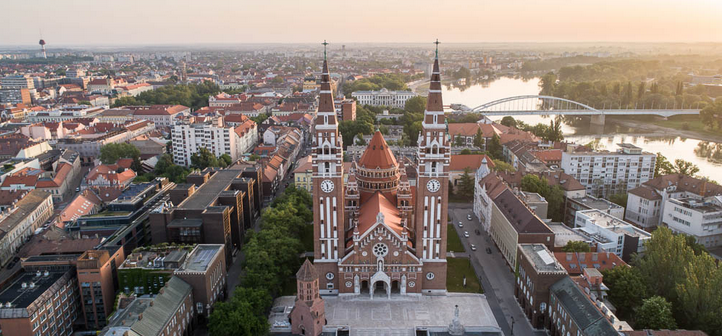

The CSV file includes a hourly/daily summary for Szeged, Hungary area, between 2006 and 2016.

Data available in the hourly response:

time<br>
summary<br>
precipType<br>
temperature<br>
apparentTemperature<br>
humidity<br>
windSpeed<br>
windBearing<br>
visibility<br>
loudCover<br>
pressure<br>


### 1) Import Libraries And Read Data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

**Read data**

In [2]:
df = pd.read_csv('/kaggle/input/szeged-weather/weatherHistory.csv')

In [3]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


### 2) Exploratory Data Analysis

**Check general info**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


**Check missing values**

In [5]:
df.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

**Catch categorical, numerical and cardinal variables**

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=30):


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'Categorical Variables: {len(cat_cols)}')
    print(f'Numerical Variables: {len(num_cols)}')
    print(f'Numerical But Categorical Variables: {len(num_but_cat)}')
    print(f'Categorical But Cardinal: {len(cat_but_car)}')
    
    return cat_cols, num_cols, cat_but_car

In [7]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 96453
Variables: 12
Categorical Variables: 3
Numerical Variables: 7
Numerical But Categorical Variables: 1
Categorical But Cardinal: 2


In [8]:
cat_but_car

['Formatted Date', 'Daily Summary']

In [9]:
cat_cols

['Summary', 'Precip Type', 'Loud Cover']

In [10]:
num_cols

['Temperature (C)',
 'Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Pressure (millibars)']

**Summarize the numerical variables**

In [11]:
def num_summary(dataframe, numerical_col, plot=False):
    print(numerical_col.upper())
    print(dataframe[numerical_col].describe().T, '\n')
    
    if plot:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=dataframe, x=numerical_col, bins=50)
        plt.title(numerical_col)
        plt.xlabel(numerical_col)
        plt.show()
       
    print('################################################################\n')

TEMPERATURE (C)
count    96453.000000
mean        11.932678
std          9.551546
min        -21.822222
25%          4.688889
50%         12.000000
75%         18.838889
max         39.905556
Name: Temperature (C), dtype: float64 



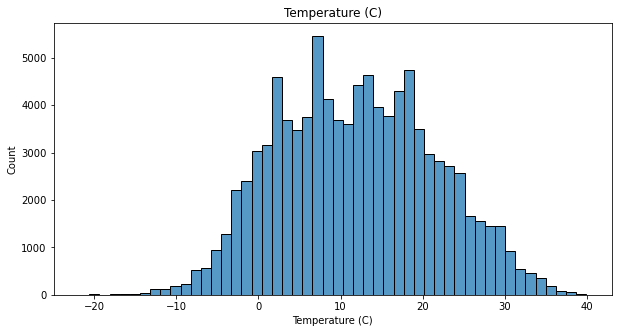

################################################################

APPARENT TEMPERATURE (C)
count    96453.000000
mean        10.855029
std         10.696847
min        -27.716667
25%          2.311111
50%         12.000000
75%         18.838889
max         39.344444
Name: Apparent Temperature (C), dtype: float64 



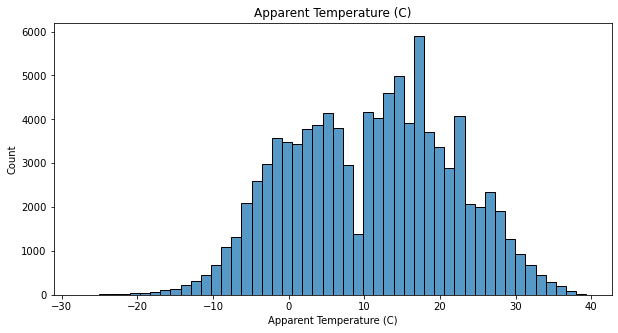

################################################################

HUMIDITY
count    96453.000000
mean         0.734899
std          0.195473
min          0.000000
25%          0.600000
50%          0.780000
75%          0.890000
max          1.000000
Name: Humidity, dtype: float64 



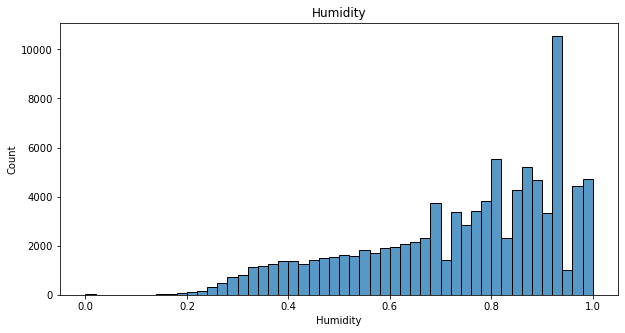

################################################################

WIND SPEED (KM/H)
count    96453.000000
mean        10.810640
std          6.913571
min          0.000000
25%          5.828200
50%          9.965900
75%         14.135800
max         63.852600
Name: Wind Speed (km/h), dtype: float64 



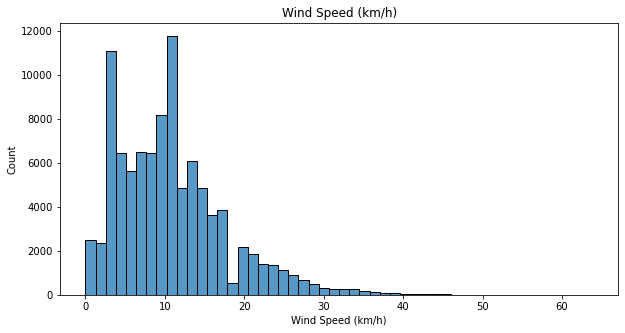

################################################################

WIND BEARING (DEGREES)
count    96453.000000
mean       187.509232
std        107.383428
min          0.000000
25%        116.000000
50%        180.000000
75%        290.000000
max        359.000000
Name: Wind Bearing (degrees), dtype: float64 



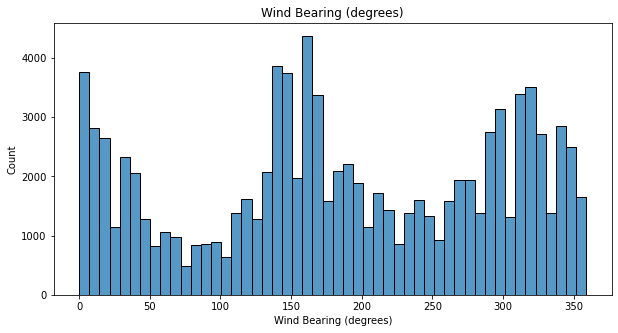

################################################################

VISIBILITY (KM)
count    96453.000000
mean        10.347325
std          4.192123
min          0.000000
25%          8.339800
50%         10.046400
75%         14.812000
max         16.100000
Name: Visibility (km), dtype: float64 



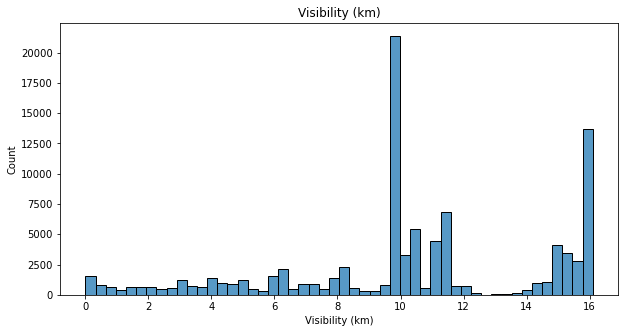

################################################################

PRESSURE (MILLIBARS)
count    96453.000000
mean      1003.235956
std        116.969906
min          0.000000
25%       1011.900000
50%       1016.450000
75%       1021.090000
max       1046.380000
Name: Pressure (millibars), dtype: float64 



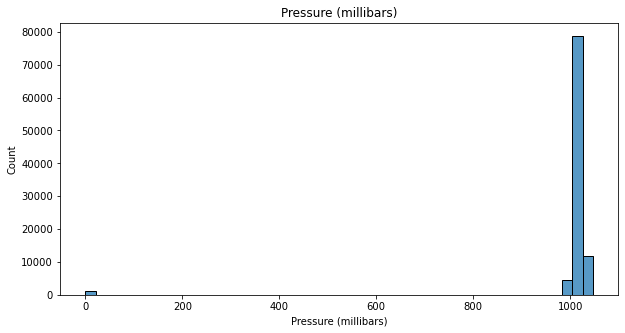

################################################################



In [12]:
for col in num_cols:
    num_summary(df, col, plot=True)

**Summarize the categrical variables**

In [13]:
cat_cols

['Summary', 'Precip Type', 'Loud Cover']

In [14]:
def cat_summary(dataframe, col_name, plot=False, figsize=(10, 5), xticks_rotation=0):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       'Ratio': round(100*(dataframe[col_name].value_counts()) / len(dataframe), 2)}))
    print('\n')
    
    if plot:
        plt.figure(figsize=figsize)
        sns.countplot(x=col_name, data=dataframe)
        plt.xticks(rotation=xticks_rotation)
        plt.show()
        
    print(120*'#', '\n')

      Precip Type  Ratio
rain        85224  88.36
snow        10712  11.11




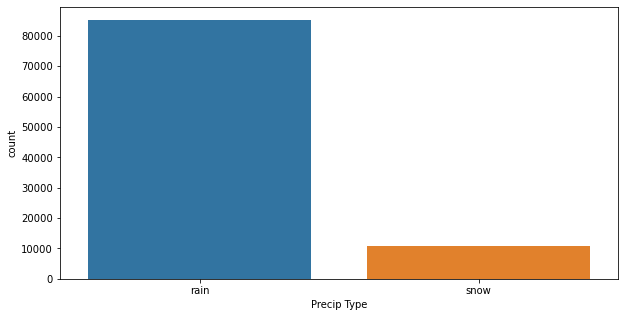

######################################################################################################################## 



In [15]:
cat_summary(df, 'Precip Type', plot=True)

                                     Summary  Ratio
Partly Cloudy                          31733  32.90
Mostly Cloudy                          28094  29.13
Overcast                               16597  17.21
Clear                                  10890  11.29
Foggy                                   7148   7.41
Breezy and Overcast                      528   0.55
Breezy and Mostly Cloudy                 516   0.53
Breezy and Partly Cloudy                 386   0.40
Dry and Partly Cloudy                     86   0.09
Windy and Partly Cloudy                   67   0.07
Light Rain                                63   0.07
Breezy                                    54   0.06
Windy and Overcast                        45   0.05
Humid and Mostly Cloudy                   40   0.04
Drizzle                                   39   0.04
Breezy and Foggy                          35   0.04
Windy and Mostly Cloudy                   35   0.04
Dry                                       34   0.04
Humid and Pa

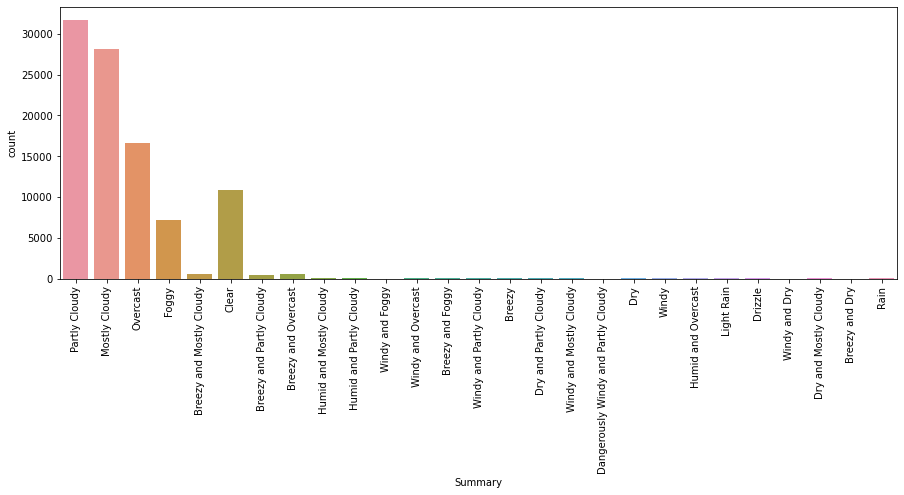

######################################################################################################################## 



In [16]:
cat_summary(df, 'Summary', plot=True, figsize=(15, 5), xticks_rotation=90)

     Loud Cover  Ratio
0.0       96453  100.0




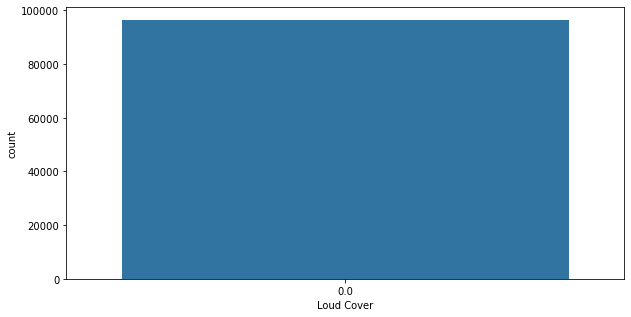

######################################################################################################################## 



In [17]:
cat_summary(df, 'Loud Cover', plot=True)

**All values of 'Loud Cover' variable are 0 so we can delete it.**

In [18]:
df.drop('Loud Cover', axis=1, inplace=True)

### Check Correlation 

In [19]:
df[num_cols].corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,0.059818
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,1.000000


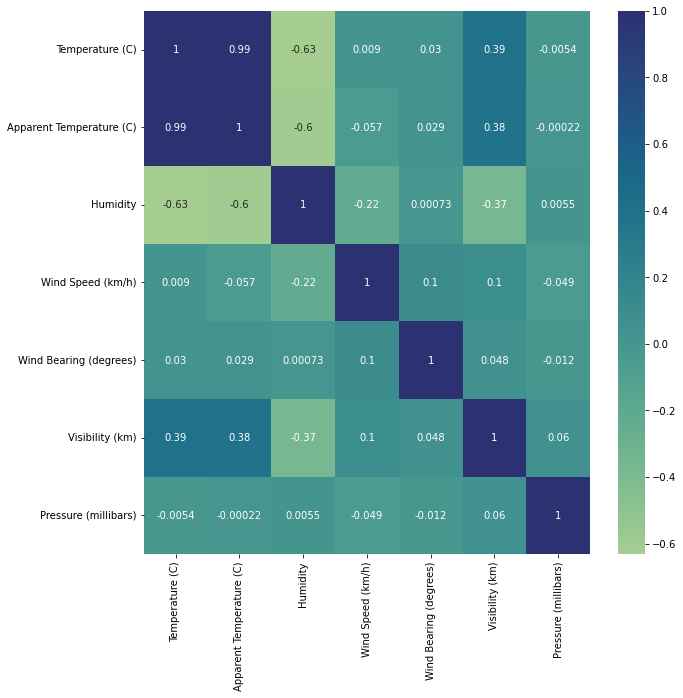

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='crest')
plt.show()

**There is highly correlation between 'Temperature' and 'Apparent Temperature' features. In this work, our target variables will be temperature, that's why I delete 'Apparent Temperature'.**

In [21]:
df.drop('Apparent Temperature (C)', axis=1, inplace=True)

**We delete 'Apparent Temperature (C)' and 'Loud Cover' so we need to reassing categorical, numerical and cardinal columns.**

In [22]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 96453
Variables: 10
Categorical Variables: 2
Numerical Variables: 6
Numerical But Categorical Variables: 0
Categorical But Cardinal: 2


### Target Variable Analysis

In [23]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({'Target Mean': dataframe.groupby(categorical_col)[target].mean()}))
    print(100*'#', '\n')

In [24]:
for col in cat_cols:
    target_summary_with_cat(df, 'Temperature (C)', col)

                                     Target Mean
Summary                                         
Breezy                                  7.922016
Breezy and Dry                         21.111111
Breezy and Foggy                       -0.510317
Breezy and Mostly Cloudy               11.093411
Breezy and Overcast                     7.241614
Breezy and Partly Cloudy               12.492761
Clear                                  11.925109
Dangerously Windy and Partly Cloudy     8.944444
Drizzle                                10.847578
Dry                                    29.083660
Dry and Mostly Cloudy                  26.838492
Dry and Partly Cloudy                  26.605749
Foggy                                   1.464035
Humid and Mostly Cloudy                20.886389
Humid and Overcast                     21.515079
Humid and Partly Cloudy                21.568301
Light Rain                             10.021517
Mostly Cloudy                          12.629334
Overcast            

### 3) Data Preprocessing and Feature Engineering

#### Outlier Analysis

In [25]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [26]:
for col in num_cols:
    print(col, f'-----There is outliers: {check_outlier(df, col, q1=0.05, q3=0.95)}')

Temperature (C) -----There is outliers: False
Humidity -----There is outliers: False
Wind Speed (km/h) -----There is outliers: True
Wind Bearing (degrees) -----There is outliers: False
Visibility (km) -----There is outliers: False
Pressure (millibars) -----There is outliers: True


**There is outliers in 'Wind Speed' and 'Pressure' variables. Let's investigate more.**

**Check 'Wind Speed (km/h)' up and down outlier limits**

In [27]:
low_limit_wind_speed, up_limit_wind_speed = outlier_thresholds(df, 'Wind Speed (km/h)', q1=0.05, q3=0.95)
print(f'Down limit of wind speed: {low_limit_wind_speed}')
print(f'Up limit of wind speed: {up_limit_wind_speed}')

Down limit of wind speed: -30.325959999999863
Up limit of wind speed: 57.28379999999977


In [28]:
df[['Wind Speed (km/h)']].describe().T

,count,mean,std,min,25%,50%,75%,max
Wind Speed (km/h),96453.0,10.81064,6.913571,0.0,5.8282,9.9659,14.1358,63.8526


In [29]:
df[df['Wind Speed (km/h)'] < low_limit_wind_speed]

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary


In [30]:
df[df['Wind Speed (km/h)'] > up_limit_wind_speed]

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
12181,2007-01-29 13:00:00.000 +0100,Dangerously Windy and Partly Cloudy,rain,8.944444,0.49,63.8526,307.0,11.4471,1009.05,Mostly cloudy throughout the day and windy sta...


**As you see above, there is only one data and we replace wind speed's of this data with threshold.**

In [31]:
replace_with_thresholds(df, 'Wind Speed (km/h)')

**Check 'Pressure (millibars)' up and down outlier limits**

In [32]:
low_limit_pressure, up_limit_pressure = outlier_thresholds(df, 'Pressure (millibars)', q1=0.05, q3=0.95)
print(f'Down limit of pressure: {low_limit_pressure}')
print(f'Up limit of pressure: {up_limit_pressure}')

Down limit of pressure: 962.715
Up limit of pressure: 1070.6750000000002


In [33]:
df[['Pressure (millibars)']].describe().T

,count,mean,std,min,25%,50%,75%,max
Pressure (millibars),96453.0,1003.235956,116.969906,0.0,1011.9,1016.45,1021.09,1046.38


In [34]:
df[df['Pressure (millibars)'] > up_limit_pressure]

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary


In [35]:
df[df['Pressure (millibars)'] < low_limit_pressure]

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
858,2006-08-14 18:00:00.000 +0200,Partly Cloudy,rain,22.477778,0.58,10.8192,159.0,11.1251,0.0,Mostly cloudy until night.
874,2006-08-15 10:00:00.000 +0200,Partly Cloudy,rain,21.061111,0.73,7.7924,264.0,11.2056,0.0,Partly cloudy until evening.
924,2006-08-17 12:00:00.000 +0200,Clear,rain,28.838889,0.51,9.6600,177.0,9.9820,0.0,Partly cloudy until morning.
945,2006-08-18 09:00:00.000 +0200,Clear,rain,24.950000,0.69,16.0195,180.0,9.9015,0.0,Partly cloudy starting overnight continuing un...
1074,2006-08-22 18:00:00.000 +0200,Partly Cloudy,rain,23.811111,0.45,16.0195,290.0,11.2056,0.0,Partly cloudy starting in the morning.
...,...,...,...,...,...,...,...,...,...,...
93147,2016-03-23 06:00:00.000 +0100,Clear,rain,2.750000,0.82,11.3988,39.0,6.1180,0.0,Overcast starting in the afternoon.
93149,2016-03-23 08:00:00.000 +0100,Clear,rain,3.838889,0.82,8.2593,58.0,6.1180,0.0,Overcast starting in the afternoon.
93150,2016-03-23 09:00:00.000 +0100,Clear,rain,5.000000,0.92,5.2486,84.0,4.9910,0.0,Overcast starting in the afternoon.
93152,2016-03-23 11:00:00.000 +0100,Clear,rain,5.050000,0.92,11.2700,10.0,4.9910,0.0,Overcast starting in the afternoon.


**There are 1288 data that pressure's value is 0. Techinacally air pressure can not be 0. Percentage of this data is 0.01 so we will delete all of them.**

In [36]:
df.drop(df[df['Pressure (millibars)'] == 0].index, inplace=True)

#### Missing Values

**Total missing values**

In [37]:
df.isnull().sum()

Formatted Date              0
Summary                     0
Precip Type               517
Temperature (C)             0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

**Missing value ratio**

In [38]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

Precip Type               0.005433
Formatted Date            0.000000
Summary                   0.000000
Temperature (C)           0.000000
Humidity                  0.000000
Wind Speed (km/h)         0.000000
Wind Bearing (degrees)    0.000000
Visibility (km)           0.000000
Pressure (millibars)      0.000000
Daily Summary             0.000000
dtype: float64

In [39]:
df[df['Precip Type'].isnull()]

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
52672,2012-04-11 16:00:00.000 +0200,Mostly Cloudy,NaN,19.016667,0.26,14.8764,163.0,9.982,1002.40,Mostly cloudy until night.
52674,2012-04-11 18:00:00.000 +0200,Mostly Cloudy,NaN,17.850000,0.28,13.7977,169.0,9.982,1001.79,Mostly cloudy until night.
52675,2012-04-11 19:00:00.000 +0200,Mostly Cloudy,NaN,16.322222,0.32,10.8192,151.0,9.982,1001.60,Mostly cloudy until night.
52677,2012-04-11 21:00:00.000 +0200,Mostly Cloudy,NaN,12.566667,0.43,9.0160,159.0,9.982,1001.92,Mostly cloudy until night.
52678,2012-04-11 22:00:00.000 +0200,Mostly Cloudy,NaN,12.927778,0.47,17.6295,197.0,16.100,1002.20,Mostly cloudy until night.
...,...,...,...,...,...,...,...,...,...,...
95584,2016-10-31 19:00:00.000 +0100,Mostly Cloudy,NaN,8.322222,0.85,8.0339,290.0,0.000,1021.73,Mostly cloudy starting in the afternoon.
95585,2016-10-31 20:00:00.000 +0100,Mostly Cloudy,NaN,7.627778,0.87,8.2271,293.0,0.000,1021.76,Mostly cloudy starting in the afternoon.
95586,2016-10-31 21:00:00.000 +0100,Mostly Cloudy,NaN,7.111111,0.89,8.5008,297.0,0.000,1021.81,Mostly cloudy starting in the afternoon.
95587,2016-10-31 22:00:00.000 +0100,Partly Cloudy,NaN,6.672222,0.90,8.6457,299.0,0.000,1021.83,Mostly cloudy starting in the afternoon.


**There are 517 missing values in 'Precip Type'. It may be show that no precip so we fill this values as 'No Precip'.**

In [40]:
df.loc[df['Precip Type'].isnull(), 'Precip Type'] = 'No Precip'

In [41]:
df['Precip Type'].value_counts()

rain         84116
snow         10532
No Precip      517
Name: Precip Type, dtype: int64

#### Feature Extraction

**Firstly, we will extract month, date and hour from 'Formatted Date'. So we need to convert variable to datetime**

In [42]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], format='%Y-%m-%d %H:%M:%S.%f %z', utc=True)

In [43]:
df.dtypes

Formatted Date            datetime64[ns, UTC]
Summary                                object
Precip Type                            object
Temperature (C)                       float64
Humidity                              float64
Wind Speed (km/h)                     float64
Wind Bearing (degrees)                float64
Visibility (km)                       float64
Pressure (millibars)                  float64
Daily Summary                          object
dtype: object

In [44]:
df['Year'] = df['Formatted Date'].dt.year
df['Month'] = df['Formatted Date'].dt.month
df['Day'] = df['Formatted Date'].dt.day
df['Hour'] = df['Formatted Date'].dt.hour

In [45]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Year,Month,Day,Hour
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,2006,3,31,22
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,2006,3,31,23
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,2006,4,1,0
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,2006,4,1,1
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,2006,4,1,2


**Now, we will delete the cardinal variables. In our data set, 'Daily Summary' and 'Formatted Date' are a cardinal variables**

In [46]:
cat_but_car

['Formatted Date', 'Daily Summary']

In [47]:
df.drop(['Formatted Date', 'Daily Summary'], axis=1, inplace=True)

In [48]:
df.head()

,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13,2006,3,31,22
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63,2006,3,31,23
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94,2006,4,1,0
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41,2006,4,1,1
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51,2006,4,1,2


**Rare Encoding**

In [49]:
def rare_encoder(dataframe, rare_perc):
    
    temp_df = df.copy()
    
    rare_colums = [col for col in temp_df.columns if ((temp_df[col].dtype == 'O') and 
                                                      ((temp_df[col].value_counts() / len(temp_df)) < rare_perc).any(axis=0))]
    
    for col in rare_colums:
        tmp = temp_df[col].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[col] = np.where(temp_df[col].isin(rare_labels), 'Rare', temp_df[col])
        
    return temp_df

In [50]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 95165
Variables: 12
Categorical Variables: 2
Numerical Variables: 10
Numerical But Categorical Variables: 0
Categorical But Cardinal: 0


**Ratio of 'Summary' variables**.

In [51]:
df['Summary'].value_counts() / len(df)

Partly Cloudy                          0.332170
Mostly Cloudy                          0.293805
Overcast                               0.172774
Clear                                  0.106783
Foggy                                  0.074082
Breezy and Overcast                    0.005517
Breezy and Mostly Cloudy               0.005370
Breezy and Partly Cloudy               0.003983
Dry and Partly Cloudy                  0.000904
Light Rain                             0.000662
Windy and Partly Cloudy                0.000662
Windy and Overcast                     0.000473
Humid and Mostly Cloudy                0.000420
Drizzle                                0.000410
Breezy and Foggy                       0.000368
Windy and Mostly Cloudy                0.000357
Dry                                    0.000357
Breezy                                 0.000315
Humid and Partly Cloudy                0.000179
Dry and Mostly Cloudy                  0.000147
Rain                                   0

**We will do rare encoding for less than %1 percentage of 'Summary' class.**

In [52]:
df = rare_encoder(df, 0.01)
df.head()

,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13,2006,3,31,22
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63,2006,3,31,23
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94,2006,4,1,0
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41,2006,4,1,1
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51,2006,4,1,2


In [53]:
df['Summary'].value_counts()

Partly Cloudy    31611
Mostly Cloudy    27960
Overcast         16442
Clear            10162
Foggy             7050
Rare              1940
Name: Summary, dtype: int64

**One Hot Encoding**

In [54]:
def one_hot_encoder(dataframe, one_hot_cols, drop_first=True):
    
    dataframe = pd.get_dummies(dataframe, columns=one_hot_cols, drop_first=drop_first)
    
    return dataframe

In [55]:
one_hot_cols = [col for col in df.columns if  10 >= df[col].nunique() > 2]
one_hot_cols

['Summary', 'Precip Type']

In [56]:
df = one_hot_encoder(df, one_hot_cols)
df.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour,Summary_Foggy,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rare,Precip Type_rain,Precip Type_snow
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,2006,3,31,22,0,0,0,1,0,1,0
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,2006,3,31,23,0,0,0,1,0,1,0
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,2006,4,1,0,0,1,0,0,0,1,0
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,2006,4,1,1,0,0,0,1,0,1,0
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,2006,4,1,2,0,1,0,0,0,1,0


**We created new features so we need to reassing numeric, categoric and cardinal columns**

In [57]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 95165
Variables: 17
Categorical Variables: 7
Numerical Variables: 10
Numerical But Categorical Variables: 7
Categorical But Cardinal: 0


#### Scaling

In [58]:
scaler = StandardScaler()

In [59]:
scaled_columns_name = df[num_cols].drop('Temperature (C)', axis=1).columns
scaled_columns_name

Index(['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
       'Visibility (km)', 'Pressure (millibars)', 'Year', 'Month', 'Day',
       'Hour'],
      dtype='object')

In [60]:
for col in scaled_columns_name:
    df[col] = scaler.fit_transform(df[[col]])

In [61]:
df.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour,Summary_Foggy,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rare,Precip Type_rain,Precip Type_snow
0,9.472222,0.792662,0.483992,0.591889,1.300518,-0.216517,-1.58417,-1.020307,1.738485,1.516359,0,0,0,1,0,1,0
1,9.355556,0.639279,0.505017,0.666373,1.300518,-0.152236,-1.58417,-1.020307,1.738485,1.660722,0,0,0,1,0,1,0
2,9.377778,0.792662,-0.994815,0.154294,1.092842,-0.112382,-1.58417,-0.729805,-1.672512,-1.659622,0,1,0,0,0,1,0
3,8.288889,0.485896,0.481655,0.759478,1.300518,-0.051957,-1.58417,-0.729805,-1.672512,-1.515259,0,0,0,1,0,1,0
4,8.755556,0.485896,0.037780,0.666373,1.300518,-0.039101,-1.58417,-0.729805,-1.672512,-1.370897,0,1,0,0,0,1,0


### 4) Model

**Assign label and features**

In [62]:
X = df.drop('Temperature (C)', axis=1)
y = df['Temperature (C)']

**Create models**

In [63]:
models = [
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())
        ]

**Evaluate models with RMSE**

In [64]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name})")

RMSE: 4.3647 (CART)
RMSE: 3.3658 (RF)
RMSE: 3.1968 (GBM)
RMSE: 3.2539 (XGBoost)
RMSE: 3.1049 (LightGBM)


**Now, we should decide for final model before hyperparameter optimization. The best model, as you see results above, is LightGBM. So we will continue with only LightGBM for hyperparameter optimization. Because it take too much computational time.**

In [65]:
lgbm_model = LGBMRegressor().fit(X, y)

In [66]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [67]:
lgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [500, 1000, 5000]}

In [68]:
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [69]:
final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)
final_model

LGBMRegressor(learning_rate=0.01, n_estimators=1000)

In [70]:
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

**Final RMSE**

In [71]:
rmse

3.082822403694937

**Feature Importance**

In [72]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

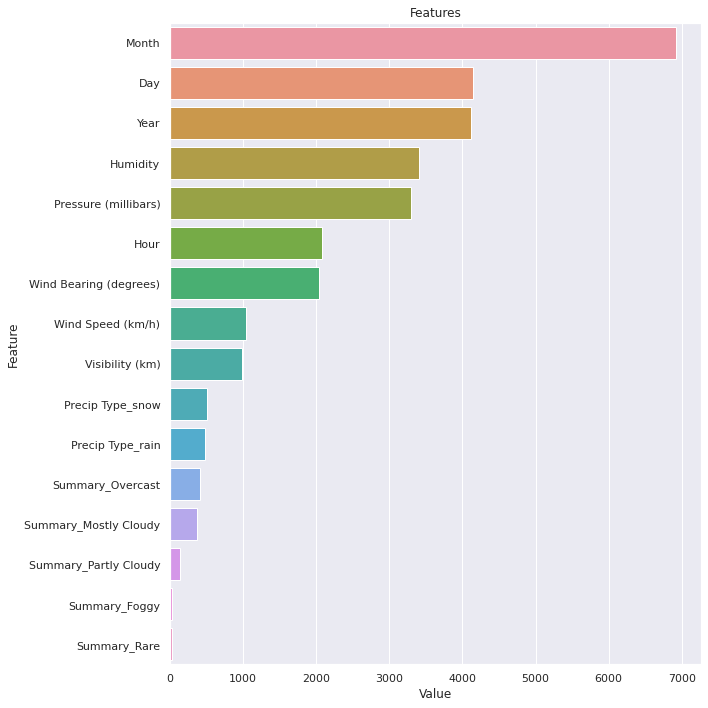

In [73]:
plot_importance(final_model, X)